# Van Gogh CycleGAN

In [3]:
# Required Libaries
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from PIL import Image

autotune = tf.data.AUTOTUNE

## Prepare the Data

In [4]:
# File folder locations for os functions
photosTrainFolder = './vangogh2photo/trainB'
photosTestFolder = './vangogh2photo/testB'
vangoghTrainFolder = './vangogh2photo/trainA'
vangoghTestFolder = './vangogh2photo/testA'

# Helper function, to convert files to np arrays that retain their colour value
read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load training images
trainPhotoImgs = [read(os.path.join(photosTrainFolder, filename)) for filename in os.listdir(photosTrainFolder)]
trainPhotos = np.array(trainPhotoImgs, dtype='uint8')
trainVanGoghImgs = [read(os.path.join(vangoghTrainFolder, filename)) for filename in os.listdir(vangoghTrainFolder)]
trainVanGogh = np.array(trainVanGoghImgs, dtype='uint8')

# Load testing images
testPhotoImgs = [read(os.path.join(photosTestFolder, filename)) for filename in os.listdir(photosTestFolder)]
testPhotos = np.array(testPhotoImgs, dtype='uint8')
testVanGoghImgs = [read(os.path.join(vangoghTestFolder, filename)) for filename in os.listdir(vangoghTestFolder)]
testVanGogh = np.array(testVanGoghImgs, dtype='uint8')

originalImgSize = (286,286)         # Set standard image size
inputImgSize = (256,256,3)          # Size of crops used in training

# Weights initialiser for the layers
kernelInit = keras.initializers.RandomNormal(mean=0.0,stddev=0.02)
# Gamma Initialiser for the instance normalisation
gammaInit = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Other variables
bufferSize = 256
batchSize = 1

# Important functions used for processing

# Map values in the range [-1,1]
def normaliseImg(img):                      
    img = tf.cast(img, dtype=tf.float32)
    return (img/127.5) - 1.0

# Prepares/resizes image for training
def preprocessTrainImage(img, label):       
    img = tf.image.random_flip_left_right(img)              # Random horizontal flip
    img = tf.image.resize(img, [*originalImgSize])          # Resize to the original size initially
    img = tf.image.random_crop(img, size=[*inputImgSize])   # Random crop to 256x256
    img = normaliseImg(img)                                 # Normalise the pixel values in range [-1,1]
    return img

# Resizes and normalises the test images
def preprocessTestImage(img, label):        
    img = tf.image.resize(img, [inputImgSize[0], inputImgSize[1]])
    img = normaliseImg(img)
    return img

## Convert the Data to 'Dataset' objects
#### This is so the data can be used for the relevant libraries

In [5]:
# Create labels for the datasets (0 for photo, 1 for painting)
trainPhotoLabels = np.zeros(trainPhotos.shape[0])
testPhotoLabels = np.zeros(testPhotos.shape[0])
trainVanGoghLabels = np.ones(trainVanGogh.shape[0])
testVanGoghLabels = np.ones(testVanGogh.shape[0])

# Create datasets for each dataset
trainPhotoDataset = tf.data.Dataset.from_tensor_slices((trainPhotos, trainPhotoLabels))
testPhotoDataset = tf.data.Dataset.from_tensor_slices((testPhotos, testPhotoLabels))
trainVanGoghDataset = tf.data.Dataset.from_tensor_slices((trainVanGogh, trainVanGoghLabels))
testVanGoghDataset = tf.data.Dataset.from_tensor_slices((testVanGogh, testVanGoghLabels))

# Preprocessing functions
def applyTrainPreprocessing(dataset):
    dataset = (dataset.map(preprocessTrainImage, num_parallel_calls=autotune)
        .cache()
        .shuffle(bufferSize)
        .batch(batchSize)
    )

    return dataset

def applyTestPreprocessing(dataset):
    dataset = (
        dataset.map(preprocessTestImage, num_parallel_calls=autotune)
        .cache()
        .shuffle(bufferSize)
        .batch(batchSize)
    )

    return dataset

# Apply preprocessing to the data
trainPhotoDataset = applyTrainPreprocessing(trainPhotoDataset)
trainVanGoghDataset = applyTrainPreprocessing(trainVanGoghDataset)
testPhotoDataset = applyTestPreprocessing(testPhotoDataset)
testVanGoghDataset = applyTestPreprocessing(testVanGoghDataset)


## Visualise the Data

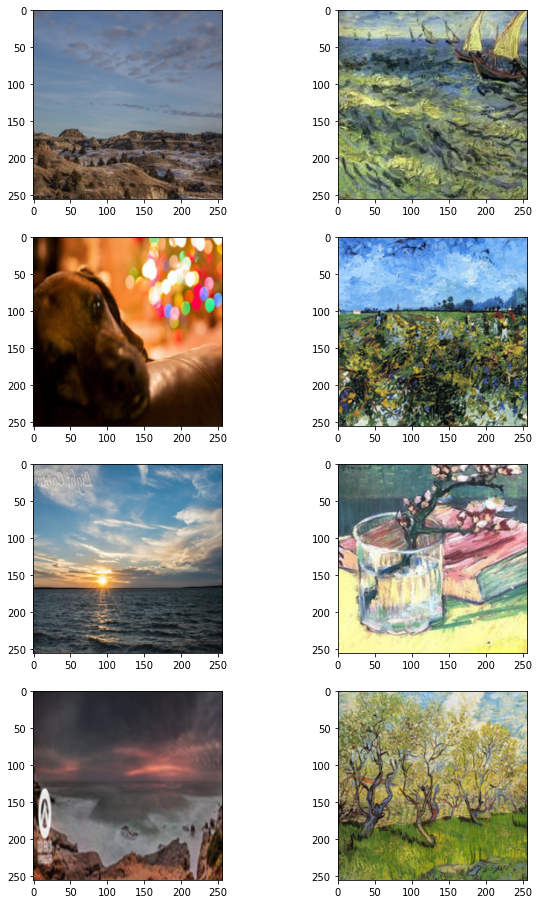

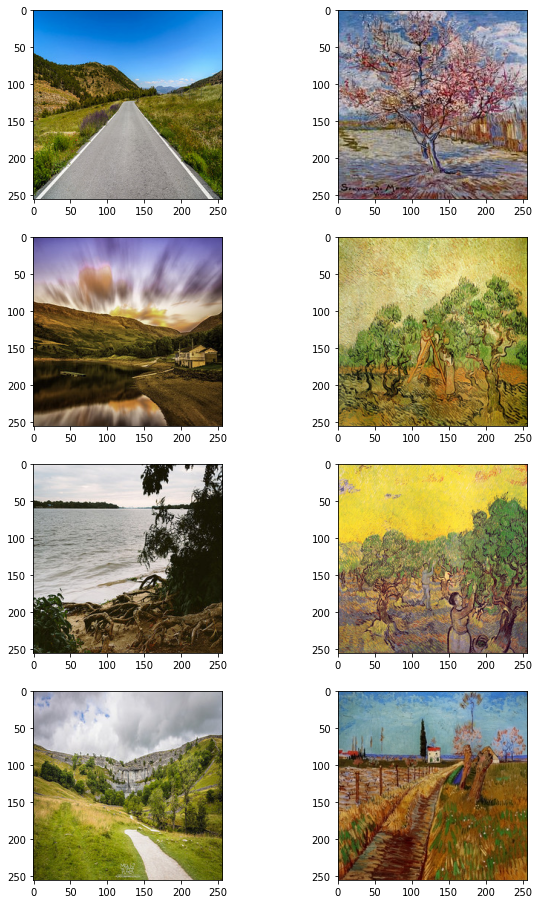

In [6]:
# Display samples of the dataset

def showPictures(dataset1, dataset2):
    _, ax = plt.subplots(4,2, figsize=(10,16))
    rows = 4

    for i, samples in enumerate(zip(dataset1.take(rows), (dataset2.take(rows)))):
        d1Sample = (((samples[0][0]* 127.5) + 127.5).numpy()).astype(np.uint8)
        d2Sample = (((samples[1][0]* 127.5) + 127.5).numpy()).astype(np.uint8)
        ax[i,0].imshow(d1Sample)
        ax[i,1].imshow(d2Sample)
    
    plt.show()

showPictures(trainPhotoDataset, trainVanGoghDataset)
showPictures(testPhotoDataset, testVanGoghDataset)


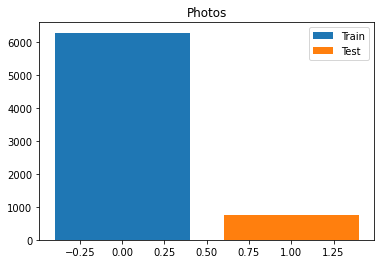

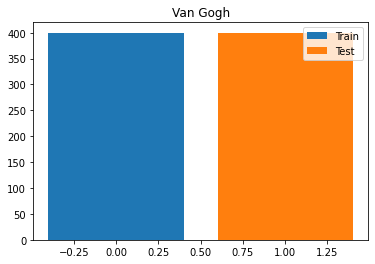

In [7]:
# Visualise the sample spread of the datasets

def sample_spread(train, test, name):
    plt.bar(0, train.cardinality(), label = 'Train')
    plt.bar(1, test.cardinality(), label = 'Test')
    plt.legend()
    plt.title(name)
    plt.show()

sample_spread(trainPhotoDataset, testPhotoDataset, 'Photos')
sample_spread(trainVanGoghDataset, testVanGoghDataset, 'Van Gogh')

# Note that the VanGogh training and testing dataset appear to be the same

## Build the Generator and Discriminator

### Define the blocks used
- #### Reflection Padding
- #### Residual Block
- #### Upsample
- #### Downsample

In [8]:
class ReflectionPadding2D(layers.Layer):
    '''
    Implements Reflection Padding as layer

    Args: 
        padding(tuple): Amount of padding for the spatial dimensions

    Returns:
        A padded tensor with the same type as the input tensor
    '''

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernelInit,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gammaInit,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernelInit,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gammaInit,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernelInit,
    gamma_initializer=gammaInit,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

### Build the Generator
#### - Starts with a Conv block with relu activiation and filter size of 7
#### - 2 downsampling blocks
#### - 9 res blocks
#### - 2 upsampling blocks
#### - Ends with a Conv block with tanh activation and filter size of 7

In [9]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gammaInit,
    name=None,
):
    img_input = layers.Input(shape=inputImgSize, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernelInit, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

### Build the Discriminator
#### Uses C64 -> C128 -> C256 -> C512 architecture

In [10]:
def get_discriminator(
    filters=64, kernel_initializer=kernelInit, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=inputImgSize, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

### Build the CycleGAN model
#### Overwrites train_step() method of Model class via fit()
#### Different kinds of losses are calculated for the generators and discriminators. To do so, the following is done:
1. Pass real images through the generators and get the generated images
2. Pass the generated images back to the generators to check if we
    we can predict the original image from the generated image.
3. Do an identity mapping of the real images using the generators.
4. Pass the generated images in 1) to the corresponding discriminators.
5. Calculate the generators total loss (adverserial + cycle + identity)
6. Calculate the discriminators loss
7. Update the weights of the generators
8. Update the weights of the discriminators
9. Return the losses in a dictionary


In [11]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Photo and y is Painting
        real_x, real_y = batch_data
        

        with tf.GradientTape(persistent=True) as tape:
            # Photo to fake VanGogh
            fake_y = self.gen_G(real_x, training=True)
            # VanGogh to fake Photo -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Photo to fake VanGogh to fake Photo): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (VanGogh to fake Photo to fake VanGogh) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

### Save Generated Images
#### Done through callback function triggered after each epoch

In [12]:
# Callback to generate and save images after each epoch
class GANMonitor(keras.callbacks.Callback):
    
    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(10, 16))
        for i, img in enumerate(testPhotoDataset.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "Generated_VanGogh_Image_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

### Train the Model

400/400 [==============================] - 5747s 14s/step - G_loss: 4.9544 - F_loss: 5.3527 - D_X_loss: 0.1272 - D_Y_loss: 0.1441


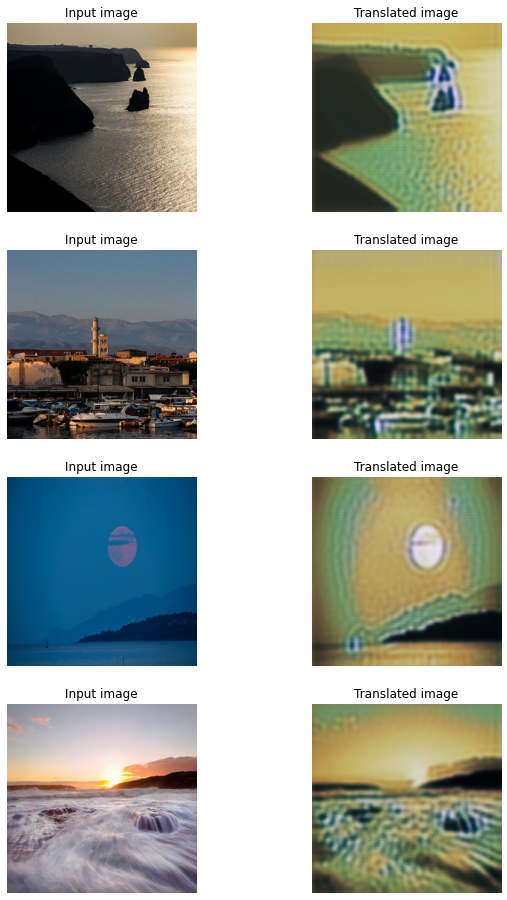

ValueError: Model <__main__.CycleGan object at 0x000002411ACB27F0> cannot be saved because the input shapes have not been set. Usually, input shapes are automatically determined from calling `.fit()` or `.predict()`. To manually set the shapes, call `model.build(input_shape)`.

In [13]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)

# Epochs can be slow to train, so be wary of how many you set
cycle_gan_model.fit(
    tf.data.Dataset.zip((trainPhotoDataset, trainVanGoghDataset)),
    epochs=50,
    callbacks=[plotter, model_checkpoint_callback],
)